## Google Colab setup

In [1]:
# you will be prompted with a window asking to grant permissions
# from google.colab import drive
# drive.mount("/content/drive")

In [2]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
# import os
# datadir = "/content/assignment4"
# if not os.path.exists(datadir):
#   !ln -s "/content/drive/MyDrive/MP4/" $datadir # TODO: Fill your Assignment 4 path
# os.chdir(datadir)
# !pwd

In [3]:
# NOTE: Loading data from Google Drive is VERY SLOW. Therefore, we download the data to a local storage
# specified by VOC_PATH.
# This means the data would have be re-downloaded everytime.
# Change this path if you are running this script locally
# VOC_PATH="./data/VOC_DATA"
 
# !chmod u+x ./download_data.sh
# !sed -i 's/\r//g' ./download_data.sh
# !cat ./download_data.sh
# !bash ./download_data.sh $VOC_PATH

## On Device Code : 

In [1]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader

from src.resnet_yolo import resnet50
import yolo_loss
from src.dataset import VocDetectorDataset
from src.eval_voc import evaluate
from src.predict_mod import predict_image
from src.config import VOC_CLASSES, COLORS
from kaggle_submission import output_submission_csv

# Extra Credits : 
from src.resnet_yolo import resnet101

import matplotlib.pyplot as plt
import collections

%matplotlib inline
%load_ext autoreload
%autoreload 2

VOC_PATH="./data/VOC_DATA"

## Initialization

In [2]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "mps"

In [3]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

## **Start from here if you modified yolo_loss.py and wish to retrain**

In [4]:
# We recommend tuning only the batch size; the remaining hyperparameters should work well
# with the default values. However, you are free to experiment with them.

learning_rate = 0.001
num_epochs = 50
batch_size = 24

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection datasets since the bounding box annotations must be kept consistent throughout the transformations.

Since the output of the detector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [5]:
file_root_train = os.path.join(VOC_PATH, 'VOCdevkit_2007/VOC2007/JPEGImages/')
annotation_file_train = 'data/voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [6]:
file_root_test = os.path.join(VOC_PATH, 'VOCdevkit_2007/VOC2007test/JPEGImages/')
annotation_file_test = 'data/voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 4950 test images


In [7]:
data = train_dataset[0]

## Initializing the network

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1 million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effectively.

In [10]:
load_network_path = "./checkpoints/best_detector.pth"
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Loading saved network from ./checkpoints/best_detector.pth


## Set up training tools

In [12]:
from importlib import reload
reload(yolo_loss) # update the import if the implementation has changed

criterion = yolo_loss.YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Train detector

In [13]:
best_test_loss = np.inf
learning_rate = learning_rate

os.makedirs('./checkpoints', exist_ok=True)
for epoch in range(num_epochs):
    net.train()

    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))

    total_loss = collections.defaultdict(int)

    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()

        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)

    # evaluate the network on the test data
    if (epoch + 1) % 5 == 0:
        test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)
        print(epoch, test_aps)
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, data in enumerate(test_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data

            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            test_loss += loss_dict['total_loss'].item()
        test_loss /= len(test_loader)

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'checkpoints/best_detector.pth')

    if (epoch+1) in [5, 10, 20, 30, 40]:
        torch.save(net.state_dict(),'checkpoints/detector_epoch_%d.pth' % (epoch+1))

    torch.save(net.state_dict(),'checkpoints/detector.pth')





Starting epoch 1 / 50
Learning Rate for this epoch: 0.001
Epoch [1/50], Iter [50/418], Loss: total=24.784, reg=47.971, containing_obj=4.042, no_obj=150.377, cls=95.017
Epoch [1/50], Iter [100/418], Loss: total=17.032, reg=42.935, containing_obj=5.164, no_obj=77.848, cls=78.438
Epoch [1/50], Iter [150/418], Loss: total=14.183, reg=40.454, containing_obj=5.940, no_obj=53.134, cls=70.673
Epoch [1/50], Iter [200/418], Loss: total=12.458, reg=38.277, containing_obj=6.497, no_obj=40.582, cls=64.137
Epoch [1/50], Iter [250/418], Loss: total=11.306, reg=36.525, containing_obj=6.913, no_obj=32.956, cls=59.275
Epoch [1/50], Iter [300/418], Loss: total=10.460, reg=35.016, containing_obj=7.308, no_obj=27.816, cls=55.375
Epoch [1/50], Iter [350/418], Loss: total=9.837, reg=34.077, containing_obj=7.555, no_obj=24.110, cls=52.297
Epoch [1/50], Iter [400/418], Loss: total=9.316, reg=33.264, containing_obj=7.776, no_obj=21.307, cls=49.442
Updating best test loss: 5.66017


Starting epoch 2 / 50
Learn

100%|██████████| 4950/4950 [01:21<00:00, 61.00it/s]


---class aeroplane ap 0.0---
---class bicycle ap 0.0--- (no predictions for this class)
---class bird ap 0.0--- (no predictions for this class)
---class boat ap 0.0--- (no predictions for this class)
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.0--- (no predictions for this class)
---class car ap 0.16058482174435745---
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.0---
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0--- (no predictions for this class)
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.10124788182831902---
---class pottedplant ap 0.0--- (no predictions for this class)
---class sheep ap 0.015938606847697757---
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.0--- (no predictions for this class)
---class tvmonito

100%|██████████| 4950/4950 [01:21<00:00, 60.41it/s]


---class aeroplane ap 0.18367973541138616---
---class bicycle ap 0.23670012515133215---
---class bird ap 0.1729280180217268---
---class boat ap 0.060507436914518375---
---class bottle ap 0.03010026654691189---
---class bus ap 0.09068857589984351---
---class car ap 0.3457935686529008---
---class cat ap 0.33956014442142035---
---class chair ap 0.10876633243100751---
---class cow ap 0.04617486338797815---
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.3243496879324446---
---class horse ap 0.422443733420414---
---class motorbike ap 0.30823326999658673---
---class person ap 0.2370006239014144---
---class pottedplant ap 0.03204060734319882---
---class sheep ap 0.0764707996151516---
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.32901273706914125---
---class tvmonitor ap 0.20331209822011004---
---map 0.17738813121687436---
9 [np.float64(0.18367973541138616), np.float64(0.23670012515133215), np.float64(0.1729280180217268), np.float

100%|██████████| 4950/4950 [01:23<00:00, 59.57it/s]


---class aeroplane ap 0.35413984965283707---
---class bicycle ap 0.3368323099429186---
---class bird ap 0.31413290438484065---
---class boat ap 0.10595146307393519---
---class bottle ap 0.035879678649541724---
---class bus ap 0.37043320804152974---
---class car ap 0.44647126377260066---
---class cat ap 0.5183491040770263---
---class chair ap 0.20222589269800623---
---class cow ap 0.3149523580299185---
---class diningtable ap 0.024058862138587732---
---class dog ap 0.5221954198021654---
---class horse ap 0.5510624969353779---
---class motorbike ap 0.36398535693999806---
---class person ap 0.2712993861055927---
---class pottedplant ap 0.08824437079777435---
---class sheep ap 0.2814854876940638---
---class sofa ap 0.14730835603234924---
---class train ap 0.3660646401418261---
---class tvmonitor ap 0.29383551231519117---
---map 0.29544539606130404---
14 [np.float64(0.35413984965283707), np.float64(0.3368323099429186), np.float64(0.31413290438484065), np.float64(0.10595146307393519), np.flo

100%|██████████| 4950/4950 [01:22<00:00, 60.15it/s]


---class aeroplane ap 0.40310581647489907---
---class bicycle ap 0.48141798205430597---
---class bird ap 0.3487277805513933---
---class boat ap 0.18602906188474763---
---class bottle ap 0.10022495121551436---
---class bus ap 0.521405474607448---
---class car ap 0.463720414637508---
---class cat ap 0.6190582472940868---
---class chair ap 0.250094919163633---
---class cow ap 0.3707368871801597---
---class diningtable ap 0.1905201278785955---
---class dog ap 0.5772777286263612---
---class horse ap 0.5954512102744284---
---class motorbike ap 0.5140829172564512---
---class person ap 0.4027700214793826---
---class pottedplant ap 0.09257574413131642---
---class sheep ap 0.29187708718096983---
---class sofa ap 0.3150298944633942---
---class train ap 0.5631513104351964---
---class tvmonitor ap 0.4869704731263028---
---map 0.38871140249580466---
19 [np.float64(0.40310581647489907), np.float64(0.48141798205430597), np.float64(0.3487277805513933), np.float64(0.18602906188474763), np.float64(0.1002

100%|██████████| 4950/4950 [01:22<00:00, 59.66it/s]


---class aeroplane ap 0.4121575753440873---
---class bicycle ap 0.5261075863072268---
---class bird ap 0.40678328781777945---
---class boat ap 0.22615615072358744---
---class bottle ap 0.12780871776274316---
---class bus ap 0.5550947873850149---
---class car ap 0.581300575513024---
---class cat ap 0.6170158659901117---
---class chair ap 0.2897077016652616---
---class cow ap 0.4605731278531531---
---class diningtable ap 0.2054631656062087---
---class dog ap 0.6007378113398973---
---class horse ap 0.5883113422502932---
---class motorbike ap 0.5241445195022687---
---class person ap 0.4262290300829794---
---class pottedplant ap 0.1293322136156958---
---class sheep ap 0.3510434232632397---
---class sofa ap 0.38761782060784833---
---class train ap 0.5127308587002193---
---class tvmonitor ap 0.44236967902799207---
---map 0.41853426201793165---
24 [np.float64(0.4121575753440873), np.float64(0.5261075863072268), np.float64(0.40678328781777945), np.float64(0.22615615072358744), np.float64(0.1278

100%|██████████| 4950/4950 [01:22<00:00, 59.70it/s]


---class aeroplane ap 0.4457212840429966---
---class bicycle ap 0.5343990531845201---
---class bird ap 0.4784740713656687---
---class boat ap 0.24960645133399884---
---class bottle ap 0.17827520841582364---
---class bus ap 0.5817168899124342---
---class car ap 0.5746041979931205---
---class cat ap 0.6026906421892126---
---class chair ap 0.3142342727087617---
---class cow ap 0.45209927224042046---
---class diningtable ap 0.34281449083347765---
---class dog ap 0.6108605564503118---
---class horse ap 0.645414781916746---
---class motorbike ap 0.593580687235842---
---class person ap 0.4500618106689623---
---class pottedplant ap 0.12732942282557008---
---class sheep ap 0.4400448226459011---
---class sofa ap 0.3809375905262562---
---class train ap 0.5477354545075366---
---class tvmonitor ap 0.4528278219107139---
---map 0.4501714391454138---
29 [np.float64(0.4457212840429966), np.float64(0.5343990531845201), np.float64(0.4784740713656687), np.float64(0.24960645133399884), np.float64(0.1782752

100%|██████████| 4950/4950 [01:20<00:00, 61.32it/s]


---class aeroplane ap 0.4395068561179829---
---class bicycle ap 0.5939915319365313---
---class bird ap 0.470761025182352---
---class boat ap 0.2633273399568671---
---class bottle ap 0.20164133537048518---
---class bus ap 0.6344774827788877---
---class car ap 0.6223367353302365---
---class cat ap 0.7009240091852982---
---class chair ap 0.31035274195149265---
---class cow ap 0.47452328573253333---
---class diningtable ap 0.3330987663976409---
---class dog ap 0.6502367217038092---
---class horse ap 0.6494428417443728---
---class motorbike ap 0.5727577290970862---
---class person ap 0.4698914882902624---
---class pottedplant ap 0.1526869483928121---
---class sheep ap 0.40196142892545617---
---class sofa ap 0.4015022769910604---
---class train ap 0.5665436446380909---
---class tvmonitor ap 0.5195430846281095---
---map 0.4714753637175684---
34 [np.float64(0.4395068561179829), np.float64(0.5939915319365313), np.float64(0.470761025182352), np.float64(0.2633273399568671), np.float64(0.201641335

100%|██████████| 4950/4950 [01:19<00:00, 62.13it/s]


---class aeroplane ap 0.4856698454609337---
---class bicycle ap 0.5824953747757668---
---class bird ap 0.49960329955604477---
---class boat ap 0.26422014983732883---
---class bottle ap 0.2201213112980711---
---class bus ap 0.6355074555519311---
---class car ap 0.6356466314704354---
---class cat ap 0.7307240140521533---
---class chair ap 0.32260728085387497---
---class cow ap 0.48504847654493966---
---class diningtable ap 0.3063991887386277---
---class dog ap 0.6551105458345282---
---class horse ap 0.6859651985946563---
---class motorbike ap 0.5838386957752553---
---class person ap 0.4971126871150713---
---class pottedplant ap 0.16566957367116303---
---class sheep ap 0.40793818744435906---
---class sofa ap 0.42489083671295097---
---class train ap 0.5914889048703296---
---class tvmonitor ap 0.5345178146901726---
---map 0.4857287736424297---
39 [np.float64(0.4856698454609337), np.float64(0.5824953747757668), np.float64(0.49960329955604477), np.float64(0.26422014983732883), np.float64(0.22

100%|██████████| 4950/4950 [01:21<00:00, 60.88it/s]


---class aeroplane ap 0.45991507450613267---
---class bicycle ap 0.624937310750135---
---class bird ap 0.49299136006451927---
---class boat ap 0.27188250996222163---
---class bottle ap 0.2191493583578652---
---class bus ap 0.6213699888270474---
---class car ap 0.6364014169533598---
---class cat ap 0.7138828011826315---
---class chair ap 0.31380007419249517---
---class cow ap 0.5259451907926034---
---class diningtable ap 0.2991397561526317---
---class dog ap 0.6572791837173706---
---class horse ap 0.6756017040411653---
---class motorbike ap 0.6131434811830112---
---class person ap 0.49458913591773696---
---class pottedplant ap 0.16438096945349082---
---class sheep ap 0.4111199478637692---
---class sofa ap 0.3948587512086585---
---class train ap 0.5851029320396224---
---class tvmonitor ap 0.5241323845885033---
---map 0.48498116658774865---
44 [np.float64(0.45991507450613267), np.float64(0.624937310750135), np.float64(0.49299136006451927), np.float64(0.27188250996222163), np.float64(0.219

100%|██████████| 4950/4950 [01:21<00:00, 60.97it/s]


---class aeroplane ap 0.43081747456740294---
---class bicycle ap 0.5762052812238612---
---class bird ap 0.4905367049118391---
---class boat ap 0.26047222702250294---
---class bottle ap 0.20886842234891734---
---class bus ap 0.6253819821754951---
---class car ap 0.6015793025462266---
---class cat ap 0.7048733280334685---
---class chair ap 0.32273240676275494---
---class cow ap 0.505260541807591---
---class diningtable ap 0.2718720835037963---
---class dog ap 0.6680028153474469---
---class horse ap 0.6727243623492292---
---class motorbike ap 0.5964010554214709---
---class person ap 0.48199655501404354---
---class pottedplant ap 0.15145047243661447---
---class sheep ap 0.38684294248521023---
---class sofa ap 0.43616714643007976---
---class train ap 0.5400808877987394---
---class tvmonitor ap 0.5092371483328232---
---map 0.4720751570259757---
49 [np.float64(0.43081747456740294), np.float64(0.5762052812238612), np.float64(0.4905367049118391), np.float64(0.26047222702250294), np.float64(0.20

### Additional Training : 

In [13]:
best_test_loss = np.inf
learning_rate = 1e-4

os.makedirs('./checkpoints', exist_ok=True)
for epoch in range(70,90):
    net.train()

    # Update learning rate late in training
    if epoch == 70 or epoch == 80 :
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

    print('\n\nStarting epoch %d / %d' % (epoch + 1, 90))
    print('Learning Rate for this epoch: {}'.format(learning_rate))

    total_loss = collections.defaultdict(int)

    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()

        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)

    # evaluate the network on the test data
    if (epoch + 1) % 5 == 0:
        test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)
        print(epoch, test_aps)
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, data in enumerate(test_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data

            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            test_loss += loss_dict['total_loss'].item()
        
        test_loss /= len(test_loader)

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'checkpoints/best_detector.pth')

    if (epoch+1) in [70,75,80,85,90]:
        torch.save(net.state_dict(),'checkpoints/detector_epoch_%d.pth' % (epoch+1))

    torch.save(net.state_dict(),'checkpoints/detector.pth')



Starting epoch 71 / 90
Learning Rate for this epoch: 1e-05
Epoch [71/50], Iter [50/418], Loss: total=1.869, reg=10.116, containing_obj=7.760, no_obj=2.527, cls=2.028
Epoch [71/50], Iter [100/418], Loss: total=1.912, reg=10.497, containing_obj=7.869, no_obj=2.542, cls=2.033
Epoch [71/50], Iter [150/418], Loss: total=1.930, reg=10.664, containing_obj=7.993, no_obj=2.500, cls=2.001
Epoch [71/50], Iter [200/418], Loss: total=1.882, reg=10.320, containing_obj=7.789, no_obj=2.506, cls=1.964
Epoch [71/50], Iter [250/418], Loss: total=1.870, reg=10.232, containing_obj=7.769, no_obj=2.494, cls=1.949
Epoch [71/50], Iter [300/418], Loss: total=1.857, reg=10.169, containing_obj=7.663, no_obj=2.495, cls=1.952
Epoch [71/50], Iter [350/418], Loss: total=1.839, reg=10.103, containing_obj=7.565, no_obj=2.499, cls=1.901
Epoch [71/50], Iter [400/418], Loss: total=1.829, reg=10.085, containing_obj=7.482, no_obj=2.508, cls=1.875
Updating best test loss: 2.57109


Starting epoch 72 / 90
Learning Rate for 

100%|██████████| 4950/4950 [01:21<00:00, 60.76it/s]


---class aeroplane ap 0.5299562381682983---
---class bicycle ap 0.5715670545823446---
---class bird ap 0.4930232974120823---
---class boat ap 0.3038687467122265---
---class bottle ap 0.22417721668525778---
---class bus ap 0.6533091344882391---
---class car ap 0.6619782642032654---
---class cat ap 0.7134041225433002---
---class chair ap 0.3234307978639409---
---class cow ap 0.5630672995670665---
---class diningtable ap 0.365472363964939---
---class dog ap 0.690987267252376---
---class horse ap 0.6952297925657264---
---class motorbike ap 0.6077162083617897---
---class person ap 0.5118192631313174---
---class pottedplant ap 0.16725289155791573---
---class sheep ap 0.48116764122634964---
---class sofa ap 0.45888799481306053---
---class train ap 0.5942455716768424---
---class tvmonitor ap 0.5591803245432951---
---map 0.5084870745659817---
74 [np.float64(0.5299562381682983), np.float64(0.5715670545823446), np.float64(0.4930232974120823), np.float64(0.3038687467122265), np.float64(0.224177216

100%|██████████| 4950/4950 [01:21<00:00, 60.91it/s]


---class aeroplane ap 0.5257450551816869---
---class bicycle ap 0.5610257157379852---
---class bird ap 0.4972056633429363---
---class boat ap 0.306967869888951---
---class bottle ap 0.2210322798060609---
---class bus ap 0.6462985046686187---
---class car ap 0.6578009367995699---
---class cat ap 0.6910480990586905---
---class chair ap 0.3239735651195177---
---class cow ap 0.5745143236516406---
---class diningtable ap 0.35806642596983623---
---class dog ap 0.7062232194039022---
---class horse ap 0.6813822642533947---
---class motorbike ap 0.5755890906069078---
---class person ap 0.5022466578642663---
---class pottedplant ap 0.1645831035169647---
---class sheep ap 0.4697873207919625---
---class sofa ap 0.4505693182720372---
---class train ap 0.5599363715481578---
---class tvmonitor ap 0.5571470274262973---
---map 0.5015571406454692---
79 [np.float64(0.5257450551816869), np.float64(0.5610257157379852), np.float64(0.4972056633429363), np.float64(0.306967869888951), np.float64(0.221032279806

100%|██████████| 4950/4950 [01:20<00:00, 61.21it/s]


---class aeroplane ap 0.5241297737531323---
---class bicycle ap 0.5749305506570388---
---class bird ap 0.48423692480489794---
---class boat ap 0.2974882081364787---
---class bottle ap 0.22494378873041268---
---class bus ap 0.6484607560339452---
---class car ap 0.6501219464439532---
---class cat ap 0.7065007790668031---
---class chair ap 0.3209945411676811---
---class cow ap 0.5568331050151077---
---class diningtable ap 0.34073561406001546---
---class dog ap 0.6906967337512329---
---class horse ap 0.6820172907354114---
---class motorbike ap 0.5782398502316015---
---class person ap 0.49929688513999265---
---class pottedplant ap 0.16783025051045292---
---class sheep ap 0.4602089899813598---
---class sofa ap 0.4613568112639612---
---class train ap 0.5854619011197804---
---class tvmonitor ap 0.5729044534552346---
---map 0.5013694577029246---
84 [np.float64(0.5241297737531323), np.float64(0.5749305506570388), np.float64(0.48423692480489794), np.float64(0.2974882081364787), np.float64(0.22494

100%|██████████| 4950/4950 [01:20<00:00, 61.32it/s]


---class aeroplane ap 0.5209412234971399---
---class bicycle ap 0.587632158093928---
---class bird ap 0.49150872578949534---
---class boat ap 0.28225038634051525---
---class bottle ap 0.23103267439360045---
---class bus ap 0.6535936798213977---
---class car ap 0.6676015889676878---
---class cat ap 0.7180329115073915---
---class chair ap 0.3213417746682846---
---class cow ap 0.5641086075879922---
---class diningtable ap 0.33504323799529734---
---class dog ap 0.7037849164613831---
---class horse ap 0.6690437451427604---
---class motorbike ap 0.5775139773719598---
---class person ap 0.5116176874694325---
---class pottedplant ap 0.1718472446192716---
---class sheep ap 0.4633252451219806---
---class sofa ap 0.47645226645504307---
---class train ap 0.5474428719716777---
---class tvmonitor ap 0.5703774681520386---
---map 0.5032246195714138---
89 [np.float64(0.5209412234971399), np.float64(0.587632158093928), np.float64(0.49150872578949534), np.float64(0.28225038634051525), np.float64(0.231032

# View example predictions

predicting...


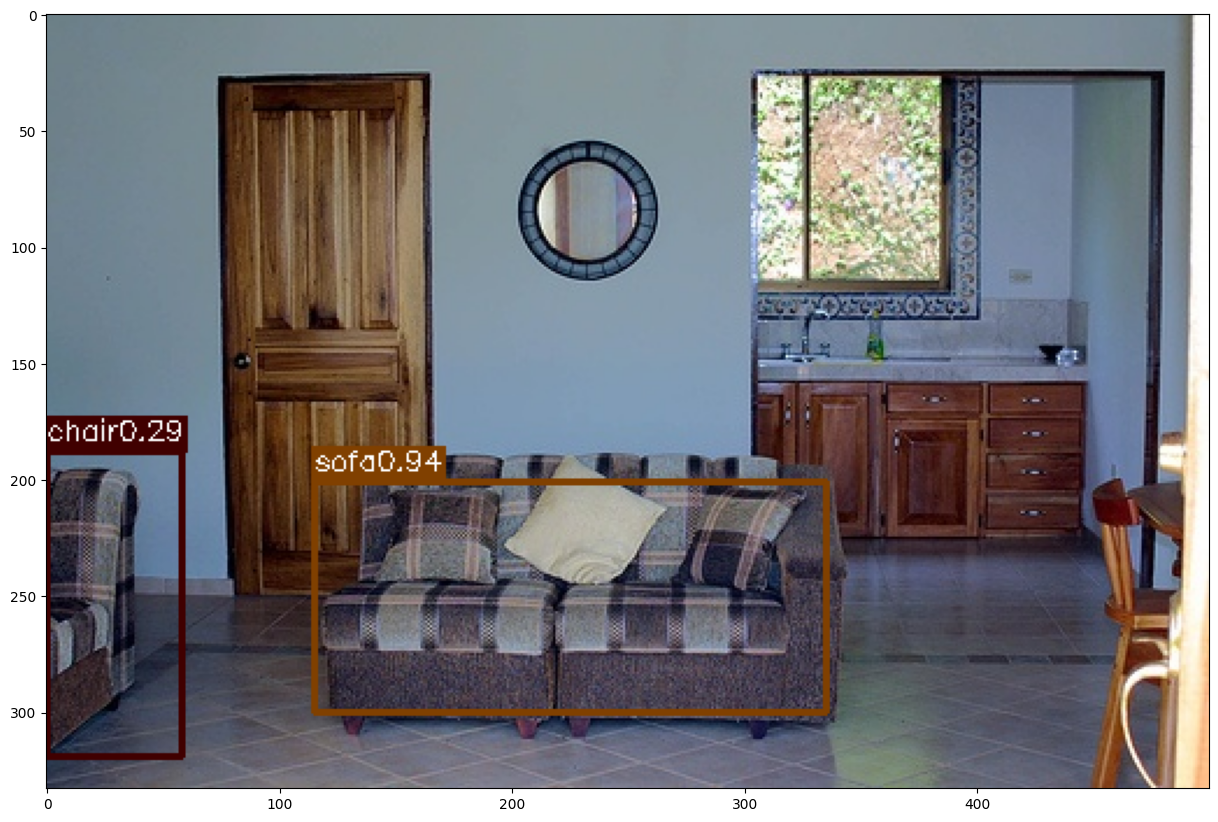

In [21]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [13]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [01:21<00:00, 60.54it/s]


---class aeroplane ap 0.5490473637280756---
---class bicycle ap 0.6044747101981405---
---class bird ap 0.49553413497444093---
---class boat ap 0.29532061741001137---
---class bottle ap 0.2239784162509651---
---class bus ap 0.6657857842546898---
---class car ap 0.6667678644586291---
---class cat ap 0.7094044642358757---
---class chair ap 0.32192744047315186---
---class cow ap 0.5696145254187923---
---class diningtable ap 0.3638505623903159---
---class dog ap 0.6938107071201558---
---class horse ap 0.6922998750019395---
---class motorbike ap 0.591010275540312---
---class person ap 0.49514150843897775---
---class pottedplant ap 0.1726609166374951---
---class sheep ap 0.4789386874835905---
---class sofa ap 0.46764503038972344---
---class train ap 0.5891271590372995---
---class tvmonitor ap 0.5633427294284274---
---map 0.5104841386435506---


### Cell added to get intermediate mAP values for students

In [17]:
network_paths = ['./checkpoints/detector_epoch_%d.pth' % epoch for epoch in [5, 10, 20, 30, 40]]+['./checkpoints/detector.pth']
for load_network_path in network_paths:
    print('Loading saved network from {}'.format(load_network_path))
    net_loaded =  resnet50().to(device)
    net_loaded.load_state_dict(torch.load(load_network_path))
    evaluate(net_loaded, test_dataset_file=annotation_file_test, img_root=file_root_test)


Loading saved network from ./checkpoints/detector_epoch_5.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [01:22<00:00, 59.73it/s]


---class aeroplane ap 0.2767838621554035---
---class bicycle ap 0.4190284215460225---
---class bird ap 0.4036919159093491---
---class boat ap 0.18487552321662498---
---class bottle ap 0.04873961177706375---
---class bus ap 0.44945574408807565---
---class car ap 0.4524046901349593---
---class cat ap 0.5532314629665958---
---class chair ap 0.13304255254422556---
---class cow ap 0.3634319457465299---
---class diningtable ap 0.08253424492515088---
---class dog ap 0.5345278862890848---
---class horse ap 0.5242471107948725---
---class motorbike ap 0.3393119854954838---
---class person ap 0.2880912141616758---
---class pottedplant ap 0.08250843827764474---
---class sheep ap 0.3375147343097732---
---class sofa ap 0.1960791715797511---
---class train ap 0.47022935239713337---
---class tvmonitor ap 0.30939262806451934---
---map 0.322456124818997---
Loading saved network from ./checkpoints/detector_epoch_10.pth
---Evaluate model on test samples---


 23%|██▎       | 1154/4950 [00:19<01:03, 59.71it/s]


KeyboardInterrupt: 

In [14]:
output_submission_csv('my_solution.csv', test_aps)

# Extra Credits
---

## <i> Object Detection on Video : <i>

In [ ]:
net.eval()

COLORS = [(np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)) for _ in VOC_CLASSES]

video_path = './test_video.mp4'
cap = cv2.VideoCapture(video_path)

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_detected.mp4', fourcc, fps, (width, height))

print("Processing video...")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    original_h, original_w = frame.shape[:2]

    resized_frame = cv2.resize(frame, (448, 448))
    rgb_resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)

    result = predict_image(net, rgb_resized_frame)  

    scale_x = original_w / 448
    scale_y = original_h / 448

    for left_up, right_bottom, class_name, _, prob in result:
        left_up = (int(left_up[0] * scale_x), int(left_up[1] * scale_y))
        right_bottom = (int(right_bottom[0] * scale_x), int(right_bottom[1] * scale_y))

        color = COLORS[VOC_CLASSES.index(class_name)]
        cv2.rectangle(frame, left_up, right_bottom, color, 2)
        label = f"{class_name} {round(prob, 2)}"
        text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
        p1 = (left_up[0], left_up[1] - text_size[1])
        cv2.rectangle(frame, (p1[0] - 1, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]), color, -1)
        cv2.putText(frame, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()
print("Done! Output saved as output_detected.mp4")

Processing video...
Done! Output saved as output_detected.mp4


## <i> Better Architecture : <i>
* 55.51 % mAP on ResNet 101 Backbone \[4% Improvement\]
* Significantly faster convergence as compared to resnet50
    * After first 5 epochs it achieves an map of 0.29 Whereas the resnet50 only achieves a map of 0.017 after 5 epochs
    * Increased Training time [ +1.5 hour ]
    * Resnet152 might perform a bit better [ ~1-2% improvement in map ], but at the cost of significantly increased computation time

### Loading / Initializing the network

In [11]:
load_network_path = "./extra_credits/best_detector_b64.pth"
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet101().to(device)
    net.load_state_dict(torch.load(load_network_path, map_location=device))
else:
    print('Load pre-trained model')
    net = resnet101(pretrained=pretrained).to(device)

Loading saved network from ./extra_credits/best_detector_b64.pth


### Training Code

In [9]:
from importlib import reload
reload(yolo_loss) # update the import if the implementation has changed

criterion = yolo_loss.YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [10]:
best_test_loss = np.inf
learning_rate = learning_rate

os.makedirs('./extra_credits', exist_ok=True)
for epoch in range(num_epochs):
    net.train()

    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))

    total_loss = collections.defaultdict(int)

    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()

        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)

    # evaluate the network on the test data
    if (epoch + 1) % 5 == 0:
        test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)
        print(epoch, test_aps)
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, data in enumerate(test_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data

            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            test_loss += loss_dict['total_loss'].item()
        test_loss /= len(test_loader)

    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'extra_credits/best_detector.pth')

    if (epoch+1) in [5, 10, 20, 30, 40]:
        torch.save(net.state_dict(),'extra_credits/detector_epoch_%d.pth' % (epoch+1))

    torch.save(net.state_dict(),'extra_credits/detector.pth')



Starting epoch 1 / 50
Learning Rate for this epoch: 0.001
Epoch [1/50], Iter [50/418], Loss: total=25.175, reg=51.370, containing_obj=4.122, no_obj=151.434, cls=95.176
Epoch [1/50], Iter [100/418], Loss: total=16.859, reg=45.582, containing_obj=5.477, no_obj=78.439, cls=72.808
Epoch [1/50], Iter [150/418], Loss: total=13.477, reg=40.826, containing_obj=6.132, no_obj=53.559, cls=61.208
Epoch [1/50], Iter [200/418], Loss: total=11.584, reg=37.614, containing_obj=6.699, no_obj=40.920, cls=53.769
Epoch [1/50], Iter [250/418], Loss: total=10.452, reg=35.827, containing_obj=7.229, no_obj=33.239, cls=49.134
Epoch [1/50], Iter [300/418], Loss: total=9.626, reg=34.340, containing_obj=7.612, no_obj=28.065, cls=45.494
Epoch [1/50], Iter [350/418], Loss: total=8.978, reg=33.077, containing_obj=7.932, no_obj=24.336, cls=42.392
Epoch [1/50], Iter [400/418], Loss: total=8.481, reg=32.025, containing_obj=8.238, no_obj=21.517, cls=39.991
Updating best test loss: 4.88103


Starting epoch 2 / 50
Learni

100%|██████████| 4950/4950 [02:01<00:00, 40.58it/s]


---class aeroplane ap 0.46772706371823003---
---class bicycle ap 0.42196787713356054---
---class bird ap 0.32291157254505043---
---class boat ap 0.11219934697887421---
---class bottle ap 0.059158178120862076---
---class bus ap 0.4115407073353621---
---class car ap 0.5733758392688486---
---class cat ap 0.25180821684066834---
---class chair ap 0.18754771464461722---
---class cow ap 0.23008275091449726---
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.5373892777971657---
---class horse ap 0.4988160202069235---
---class motorbike ap 0.3951549992186495---
---class person ap 0.324258558110198---
---class pottedplant ap 0.07706732521862347---
---class sheep ap 0.19933038136760897---
---class sofa ap 0.050096961861667746---
---class train ap 0.5325052305292071---
---class tvmonitor ap 0.3323169349362072---
---map 0.2992627478373411---
4 [np.float64(0.46772706371823003), np.float64(0.42196787713356054), np.float64(0.32291157254505043), np.float64(0.112199346978

100%|██████████| 4950/4950 [01:59<00:00, 41.27it/s]


---class aeroplane ap 0.4510270878696761---
---class bicycle ap 0.49962451672517394---
---class bird ap 0.44781570246153923---
---class boat ap 0.2994626342780562---
---class bottle ap 0.12679110127292953---
---class bus ap 0.5551049112622599---
---class car ap 0.6174061123258177---
---class cat ap 0.6890868295657269---
---class chair ap 0.23617150729826733---
---class cow ap 0.5135827682228067---
---class diningtable ap 0.23963882132143646---
---class dog ap 0.6599721412306252---
---class horse ap 0.6284184230631831---
---class motorbike ap 0.42403902455600906---
---class person ap 0.3977989147634756---
---class pottedplant ap 0.12041460288354328---
---class sheep ap 0.3794407675514796---
---class sofa ap 0.45519266261255453---
---class train ap 0.6074999880457039---
---class tvmonitor ap 0.4488959299565253---
---map 0.4398692223633395---
9 [np.float64(0.4510270878696761), np.float64(0.49962451672517394), np.float64(0.44781570246153923), np.float64(0.2994626342780562), np.float64(0.12

100%|██████████| 4950/4950 [01:59<00:00, 41.50it/s]


---class aeroplane ap 0.5077722484670739---
---class bicycle ap 0.5679946610110966---
---class bird ap 0.48360667582250033---
---class boat ap 0.38122549364634006---
---class bottle ap 0.1582925641015865---
---class bus ap 0.5624836012141325---
---class car ap 0.6638103168221916---
---class cat ap 0.7388028034765087---
---class chair ap 0.287736474066199---
---class cow ap 0.5135435966672526---
---class diningtable ap 0.20905209076273---
---class dog ap 0.6981793730599894---
---class horse ap 0.6189349332834109---
---class motorbike ap 0.5409902954469886---
---class person ap 0.4738364954878085---
---class pottedplant ap 0.21815447053559592---
---class sheep ap 0.41996273994764993---
---class sofa ap 0.48868550811684985---
---class train ap 0.669126907435722---
---class tvmonitor ap 0.5098432541532523---
---map 0.485601725176244---
14 [np.float64(0.5077722484670739), np.float64(0.5679946610110966), np.float64(0.48360667582250033), np.float64(0.38122549364634006), np.float64(0.158292564

100%|██████████| 4950/4950 [01:58<00:00, 41.62it/s]


---class aeroplane ap 0.5172653058236181---
---class bicycle ap 0.577994781479211---
---class bird ap 0.4762045960185878---
---class boat ap 0.3537658611792158---
---class bottle ap 0.16277297796136816---
---class bus ap 0.6273517586984205---
---class car ap 0.6347198382885905---
---class cat ap 0.7317086626221598---
---class chair ap 0.30411971195071597---
---class cow ap 0.48767464513658365---
---class diningtable ap 0.38207965510498026---
---class dog ap 0.6579992898651037---
---class horse ap 0.6500190724804331---
---class motorbike ap 0.533863639591915---
---class person ap 0.48516404159583354---
---class pottedplant ap 0.2207917598683525---
---class sheep ap 0.47163135285494523---
---class sofa ap 0.5310425047314017---
---class train ap 0.6278135308203507---
---class tvmonitor ap 0.5063604423391667---
---map 0.4970171714205477---
19 [np.float64(0.5172653058236181), np.float64(0.577994781479211), np.float64(0.4762045960185878), np.float64(0.3537658611792158), np.float64(0.16277297

100%|██████████| 4950/4950 [01:58<00:00, 41.64it/s]


---class aeroplane ap 0.4638238159231867---
---class bicycle ap 0.6380388581377301---
---class bird ap 0.5801429206319022---
---class boat ap 0.3440841723240549---
---class bottle ap 0.1992474110918106---
---class bus ap 0.6411941592801486---
---class car ap 0.676073505580467---
---class cat ap 0.7498474424478299---
---class chair ap 0.34581067596037784---
---class cow ap 0.5713194637191314---
---class diningtable ap 0.3672271609068306---
---class dog ap 0.7159850045220416---
---class horse ap 0.6567277318714836---
---class motorbike ap 0.5960525303180644---
---class person ap 0.5107917935080688---
---class pottedplant ap 0.24398406883588777---
---class sheep ap 0.4831477987885857---
---class sofa ap 0.5842916134223191---
---class train ap 0.6652396249691388---
---class tvmonitor ap 0.550531004230882---
---map 0.5291780378234971---
24 [np.float64(0.4638238159231867), np.float64(0.6380388581377301), np.float64(0.5801429206319022), np.float64(0.3440841723240549), np.float64(0.19924741109

100%|██████████| 4950/4950 [02:01<00:00, 40.71it/s]


---class aeroplane ap 0.5273879753798114---
---class bicycle ap 0.6446629341071888---
---class bird ap 0.4814581610229061---
---class boat ap 0.3966838009396087---
---class bottle ap 0.250372088268189---
---class bus ap 0.6746957723189769---
---class car ap 0.646354390202583---
---class cat ap 0.7122411449986576---
---class chair ap 0.3416975779933579---
---class cow ap 0.5469558333279303---
---class diningtable ap 0.2837861458108217---
---class dog ap 0.7147229892661594---
---class horse ap 0.6317399451695183---
---class motorbike ap 0.5929597913511118---
---class person ap 0.5131339444026316---
---class pottedplant ap 0.2353014000454196---
---class sheep ap 0.4462077044228828---
---class sofa ap 0.5238397015415499---
---class train ap 0.7032569144184273---
---class tvmonitor ap 0.558419642197297---
---map 0.5212938928592513---
29 [np.float64(0.5273879753798114), np.float64(0.6446629341071888), np.float64(0.4814581610229061), np.float64(0.3966838009396087), np.float64(0.25037208826818

100%|██████████| 4950/4950 [01:58<00:00, 41.60it/s]


---class aeroplane ap 0.5213688293414556---
---class bicycle ap 0.6894731990469767---
---class bird ap 0.599630041691289---
---class boat ap 0.4010782233323783---
---class bottle ap 0.2700601335599768---
---class bus ap 0.6839871414873107---
---class car ap 0.7154505904299755---
---class cat ap 0.7561135474624714---
---class chair ap 0.3865633813768396---
---class cow ap 0.6055628328766971---
---class diningtable ap 0.35654872568809026---
---class dog ap 0.7373384790314164---
---class horse ap 0.689445866413464---
---class motorbike ap 0.6081779873782962---
---class person ap 0.5817569083733598---
---class pottedplant ap 0.25636882258509286---
---class sheep ap 0.5013350644362538---
---class sofa ap 0.5570547464513754---
---class train ap 0.6794268503420741---
---class tvmonitor ap 0.5461767716773427---
---map 0.557145907149107---
34 [np.float64(0.5213688293414556), np.float64(0.6894731990469767), np.float64(0.599630041691289), np.float64(0.4010782233323783), np.float64(0.2700601335599

100%|██████████| 4950/4950 [01:59<00:00, 41.57it/s]


---class aeroplane ap 0.499352419702537---
---class bicycle ap 0.6772978143100215---
---class bird ap 0.5538883842762437---
---class boat ap 0.39841652270868855---
---class bottle ap 0.2649924433263383---
---class bus ap 0.6919257442162468---
---class car ap 0.6820584478593728---
---class cat ap 0.7528702861421044---
---class chair ap 0.36223865538441136---
---class cow ap 0.6007849520358026---
---class diningtable ap 0.3927170450486537---
---class dog ap 0.7360146702365419---
---class horse ap 0.6790379099017219---
---class motorbike ap 0.6250073566475082---
---class person ap 0.5651160243839046---
---class pottedplant ap 0.24894143869561097---
---class sheep ap 0.49845120455219605---
---class sofa ap 0.5543515569111426---
---class train ap 0.6585767403586742---
---class tvmonitor ap 0.5898163911546533---
---map 0.5515928003926187---
39 [np.float64(0.499352419702537), np.float64(0.6772978143100215), np.float64(0.5538883842762437), np.float64(0.39841652270868855), np.float64(0.26499244

100%|██████████| 4950/4950 [02:02<00:00, 40.39it/s]


---class aeroplane ap 0.5166011138555395---
---class bicycle ap 0.6840318924386034---
---class bird ap 0.5924899541619377---
---class boat ap 0.39448785897076216---
---class bottle ap 0.24854959961653414---
---class bus ap 0.670929619298966---
---class car ap 0.6888074723707043---
---class cat ap 0.7409050211395873---
---class chair ap 0.3642125076057833---
---class cow ap 0.6063624894430109---
---class diningtable ap 0.3814580440704946---
---class dog ap 0.7294943739194812---
---class horse ap 0.6775908232679706---
---class motorbike ap 0.6196725400586818---
---class person ap 0.568476958271711---
---class pottedplant ap 0.2354624323475677---
---class sheep ap 0.5182094874968339---
---class sofa ap 0.5408081043627433---
---class train ap 0.6595605323005129---
---class tvmonitor ap 0.5665310911630779---
---map 0.5502320958080252---
44 [np.float64(0.5166011138555395), np.float64(0.6840318924386034), np.float64(0.5924899541619377), np.float64(0.39448785897076216), np.float64(0.2485495996

100%|██████████| 4950/4950 [02:03<00:00, 40.20it/s]


---class aeroplane ap 0.49906027760879484---
---class bicycle ap 0.71445761087761---
---class bird ap 0.5822160679434836---
---class boat ap 0.3857716185054886---
---class bottle ap 0.2680252286661407---
---class bus ap 0.699182229192286---
---class car ap 0.6735093021256975---
---class cat ap 0.7674281652266652---
---class chair ap 0.38529697624398246---
---class cow ap 0.5600637543060969---
---class diningtable ap 0.38098818973888005---
---class dog ap 0.7229825781997219---
---class horse ap 0.6868172835230202---
---class motorbike ap 0.6143811110350244---
---class person ap 0.5687176165062535---
---class pottedplant ap 0.2350094192487198---
---class sheep ap 0.5090415688667449---
---class sofa ap 0.5363211043583915---
---class train ap 0.6662828788608024---
---class tvmonitor ap 0.5836405744136829---
---map 0.5519596777723743---
49 [np.float64(0.49906027760879484), np.float64(0.71445761087761), np.float64(0.5822160679434836), np.float64(0.3857716185054886), np.float64(0.268025228666

### Loading Best Model and Testing it

In [ ]:
load_network_path = "./extra_credits/best_detector.pth"
print('Loading saved network from {}'.format(load_network_path))
net = resnet101().to(device)
net.load_state_dict(torch.load(load_network_path))

Loading saved network from ./extra_credits/best_detector.pth


predicting...


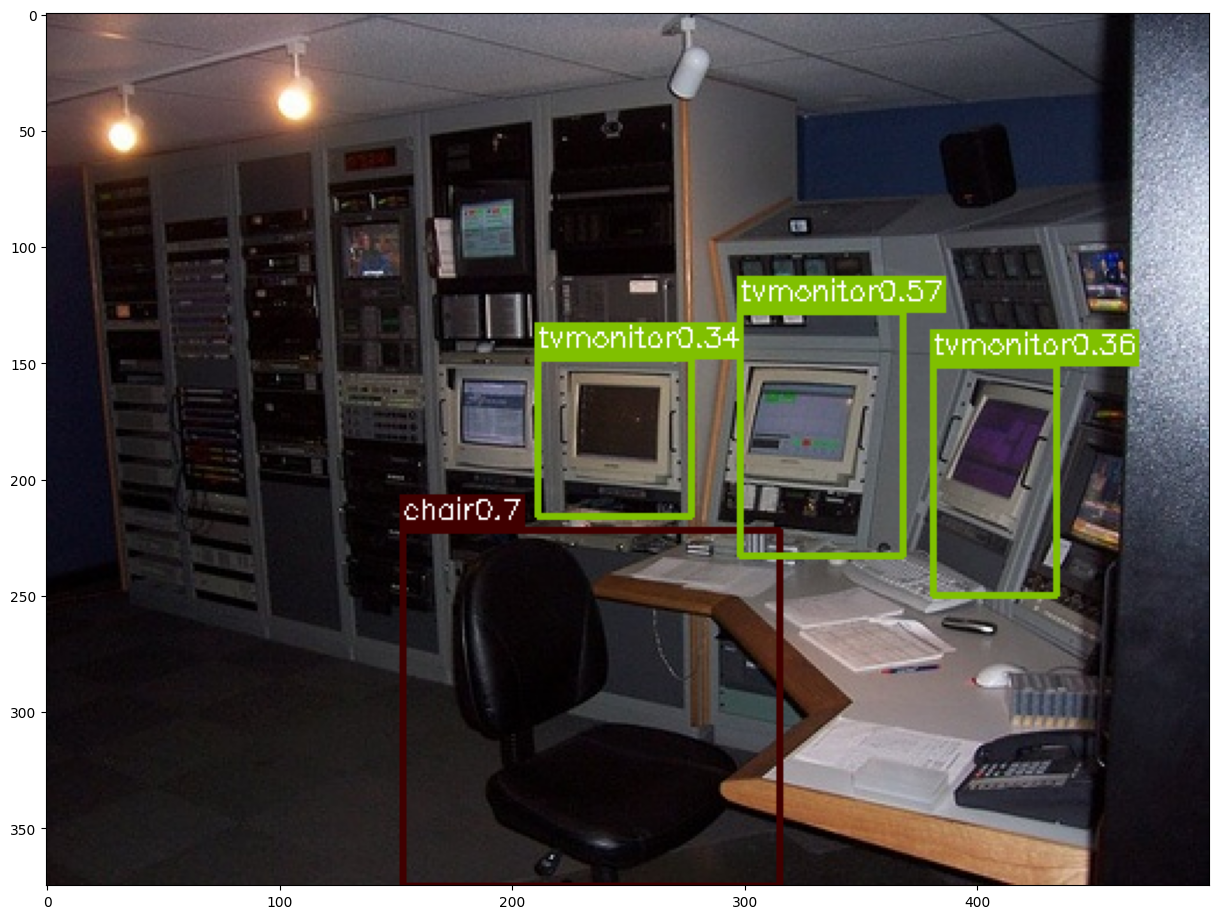

In [16]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


predicting...


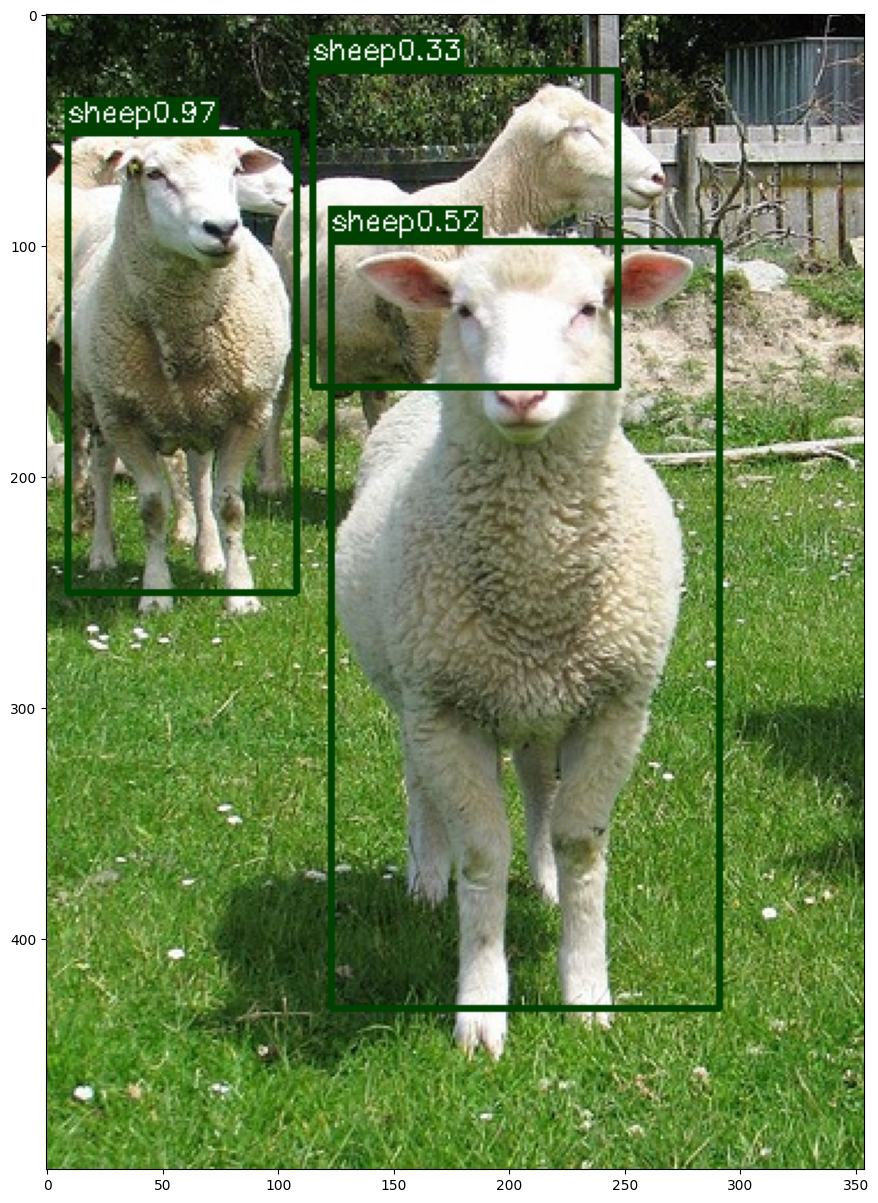

In [29]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


In [12]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [02:03<00:00, 40.13it/s]


---class aeroplane ap 0.624562587178258---
---class bicycle ap 0.7050873798697145---
---class bird ap 0.6353052141097612---
---class boat ap 0.40470320407946697---
---class bottle ap 0.3386257304691164---
---class bus ap 0.7037902235735767---
---class car ap 0.7132922104763764---
---class cat ap 0.7842084856510338---
---class chair ap 0.39717608440927565---
---class cow ap 0.6458030603362903---
---class diningtable ap 0.4077314510435983---
---class dog ap 0.7783479186991804---
---class horse ap 0.7260397970369641---
---class motorbike ap 0.66670466071377---
---class person ap 0.6075107000548832---
---class pottedplant ap 0.2631345245951537---
---class sheep ap 0.6140387425622209---
---class sofa ap 0.5530633959906333---
---class train ap 0.7358782510155377---
---class tvmonitor ap 0.6449599296037619---
---map 0.5974981775734287---
